In [1]:
#!pip install -U pandas
#!pip install pyarrow
#!pip install fastparquet

In [2]:
!python -V

Python 3.9.13


In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experimentc")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experimentc', tags={}>

In [5]:
file_path_train = "./../data/green_tripdata_2021-01.parquet"
file_path_test = "./../data/green_tripdata_2021-02.parquet"

In [6]:
# Read in Data
df = pd.read_parquet(file_path_train)

In [7]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
# Select 3 features as train features
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [9]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829435

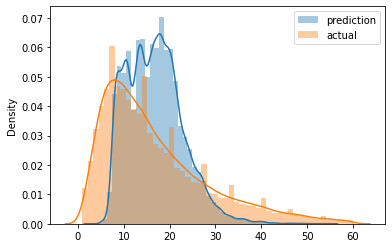

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe(file_path_train)
df_val = read_dataframe(file_path_test)

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [18]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [41]:
# Single model logging
with mlflow.start_run():

    mlflow.set_tag("developer", "wasurat")

    mlflow.log_param("train-data-path", file_path_train)
    mlflow.log_param("valid-data-path", file_path_test)

    alpha = 0.05
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models_pickle")

### Experiment Tracking

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

#### Hyperparameter Tuning

In [ ]:
# Search Space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# Experimentation
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

### Model Logging

In [42]:
mlflow.xgboost.autolog(disable = True)
# Logging Best Model 
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label = y_train)
    valid = xgb.DMatrix(X_val, label = y_val)

    # Best model from hyperparameter tuning
    params = {
        'learning_rate': 0.204721,
        'max_depth': 19,
        'min_child_weight': 1.24026,
        'objective': 'reg:linear',
        'reg_alpha': 0.2856789,
        'reg_lambda': 0.0042644,
        'seed': 42,
    }
    mlflow.log_params(params)
    
    booster = xgb.train(params = params,
                        dtrain = train,
                        num_boost_round = 1000,
                        evals = [(valid, 'validation')],
                        early_stopping_rounds = 50)
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    # Log model as artifact (No framework specific)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path ="preprocessor")
    # Log model using log_model (framework specific)
    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")

[11:16:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.57523
[1]	validation-rmse:14.77909
[2]	validation-rmse:12.64213
[3]	validation-rmse:11.02559
[4]	validation-rmse:9.81711
[5]	validation-rmse:8.92932
[6]	validation-rmse:8.28559
[7]	validation-rmse:7.81948
[8]	validation-rmse:7.48532
[9]	validation-rmse:7.24124
[10]	validation-rmse:7.06533
[11]	validation-rmse:6.93603
[12]	validation-rmse:6.84287
[13]	validation-rmse:6.77181
[14]	validation-rmse:6.71874
[15]	validation-rmse:6.67737
[16]	validation-rmse:6.64768
[17]	validation-rmse:6.62318
[18]	validation-rmse:6.60428
[19]	validation-rmse:6.58985
[20]	validation-rmse:6.57998
[21]	validation-rmse:6.57292
[22]	validation-rmse:6.56744
[23]	validation-rmse:6.56144
[24]	validation-rmse:6.55560
[25]	validation-rmse:6.55203
[26]	validation-rmse:6.54896
[27]	validation

### Model Usage from Mlflow log

In [43]:
## Testing call model
logged_model = 'runs:/fe9eea2587ff4568b5cc785d88f4a981/models_mlflow'
loadded_model = mlflow.pyfunc.load_model(logged_model)

[11:28:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [46]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
y_pred = xgboost_model.predict(valid)

y_pred[:10]

[11:55:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


array([15.019348 ,  7.2207594, 13.418636 , 24.378086 ,  9.006579 ,
       17.134077 , 11.80114  ,  8.730892 ,  8.974782 , 19.703083 ],
      dtype=float32)

### Multiple Model Logging

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

In [30]:
model_collection = { "RandomForest" : RandomForestRegressor,
                     "GradientBoosting" : GradientBoostingRegressor,
                     "ExtraTree" : ExtraTreesRegressor,
                     "LinearSVR" : LinearSVR
                    }

In [37]:
for model_name, model_class in model_collection.items():
    with mlflow.start_run():
        mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.csv")
       
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        # Log model as artifact (No framework specific)
        with open(f'../models/{model_name}_regressor.bin', 'wb') as f_out:
            pickle.dump(mlmodel, f_out)
        
        mlflow.log_artifact(f"../models/{model_name}_regressor.bin", artifact_path = f"{model_name}_regressor")
        
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)